In [153]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [154]:
df = pd.read_csv('unified_genotypes_preprocessed_final_v2 - unified_genotypes_preprocessed_final_v2.csv')
# df = df.drop(columns=[col for col in df.columns if col.startswith('chrX') or col.startswith('chrY')])

In [155]:
df.shape

(234, 4509)

In [156]:
df.head()

,patient_id,group,chr1_826893,chr1_941119,chr1_952421,chr1_953259,chr1_953279,chr1_961945,chr1_962184,chr1_979847,...,chrX_145823364,chrX_150762633,chrX_151700795,chrX_152850288,chrX_153776089,chrX_154412069,chrX_156023167,chrX_156023436,vaccination,risk
0,UFES_001,1,1,1,1,1,1,1,1,0,...,1,1,1,0,1,1,1,1,0.0,1
1,UFES_003,0,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,0,0,0.0,0
2,UFES_006,1,1,1,1,1,1,1,1,0,...,2,2,2,2,2,2,1,1,0.0,1
3,UFES_008,1,0,1,1,1,1,1,1,1,...,1,1,1,0,1,1,0,0,0.0,1
4,UFES_010,1,0,1,1,1,1,1,1,1,...,2,2,2,2,2,2,1,1,0.0,1


In [157]:

# Separar características (X) y etiquetas (y)
X = df.drop(columns=['group', 'patient_id', 'risk'])
y = df['group']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [158]:
# Criar uma instancia de XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Treinar
model.fit(X_train, y_train)

# Obter a importância das características
importance = model.feature_importances_

# Criar un DataFrame com a importancia das características
# NOTE: excluir ID
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
})

# Ordenar el DataFrame por importancia
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

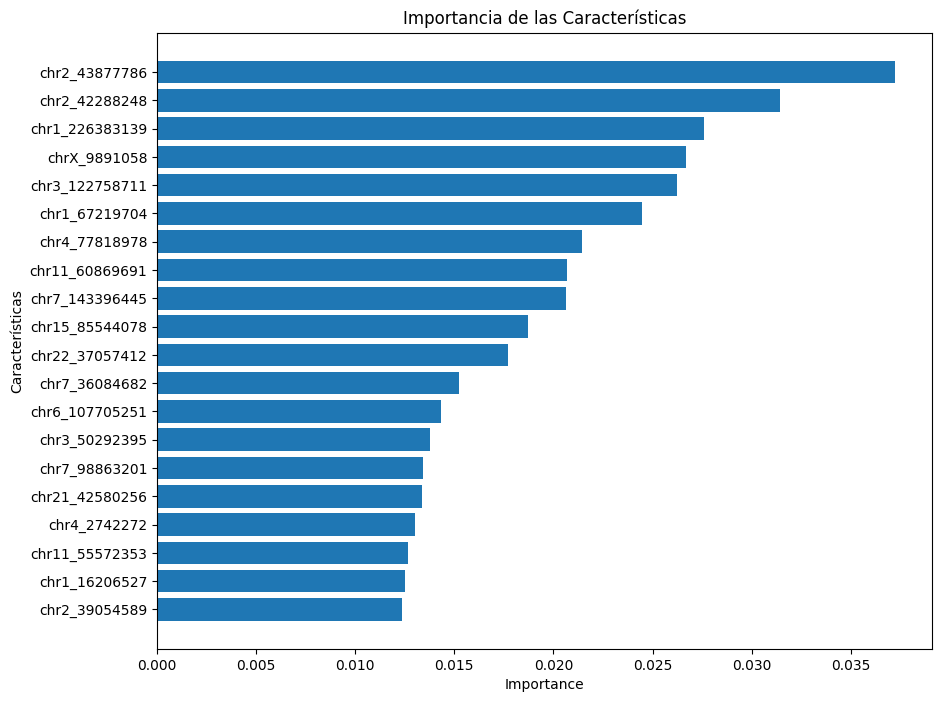

In [159]:
# Visualizar as 20 características mais importantes
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['feature'][:20], feature_importance_df['importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()
plt.show()


In [160]:
# Seleccionar as N características mais importantes (por exemplo, as 20 más importantes)
top_features = feature_importance_df['feature'][:20]

# Criar um novo conjunto de dados com as características selecionadas
X_train = X_train[:, top_features.index]
X_test = X_test[:, top_features.index]

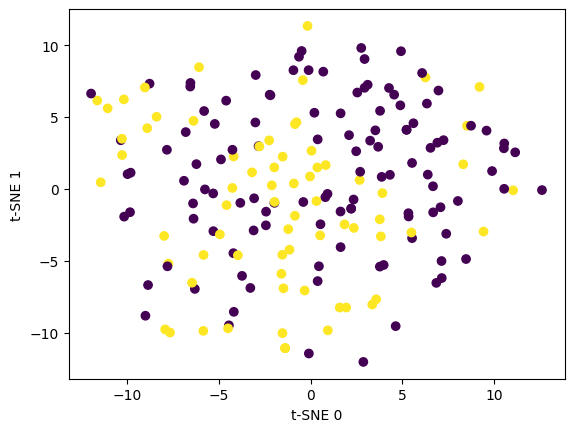

In [161]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis')
plt.xlabel('t-SNE 0')
plt.ylabel('t-SNE 1')
plt.show()

In [162]:

# Treinar un novo modelo XGBoost con as características selecionadas
model_final = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model_final.fit(X_train, y_train)

# Fazer predições e validar o modelo final
y_pred = model_final.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.72


              precision    recall  f1-score   support

           0       0.76      0.84      0.80        31
           1       0.62      0.50      0.55        16

    accuracy                           0.72        47
   macro avg       0.69      0.67      0.68        47
weighted avg       0.71      0.72      0.72        47



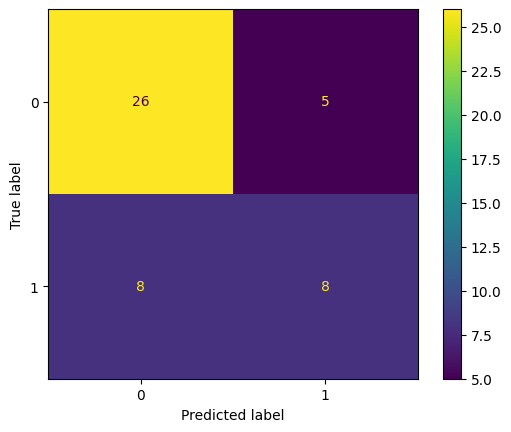

In [163]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_final.classes_)
disp.plot()
plt.show()